In [15]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [58]:
toxic_x_test = pd.read_csv('test.csv',index_col='id')
toxic_y_test=pd.read_csv('test_labels.csv',index_col='id')
toxic_test=toxic_x_test.join(toxic_y_test, on='id')
toxic_test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [59]:
toxic_train = pd.read_csv('train.csv',index_col='id')
toxic_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [60]:
nrow_train=toxic_train.shape[0]
nrow_test=toxic_test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


It seems that the train data is almost the same size as the test data

# Check for duplicate and null values

In [61]:
toxic_train[toxic_train.duplicated('comment_text')]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,


In [62]:
toxic_train.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# Exploratory Data Analysis

Add the clean column

In [63]:
x=toxic_train.iloc[:,1:].sum()
#marking comments without any tags as "clean"
rowsums=toxic_train.iloc[:,1:].sum(axis=1)
toxic_train['clean']=(rowsums==0)
#count number of clean entries
toxic_train['clean'].sum()
print("Total comments = ",len(toxic_train))
print("Total clean comments = ",toxic_train['clean'].sum())
print("Total tags =",x.sum())
toxic_train.head()

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


Add length of the comment to analyze

In [64]:
toxic_train['length'] = toxic_train['comment_text'].apply(len)
toxic_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,length
id,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,67


## Data Validation

In [65]:
toxic_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,394.073221
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,590.720282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,435.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


It seems like the data is imbalanced

## Data Visualization

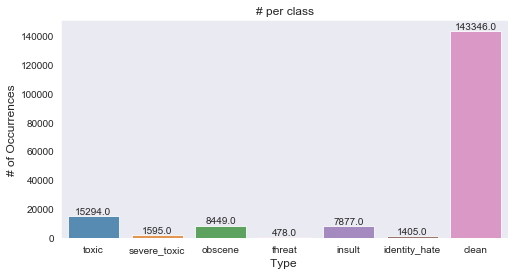

In [66]:
x=toxic_train.iloc[:,1:-1].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Example Comments:
Let's see the example of each comment to get better understanding

In [71]:
print("toxic:")
print(toxic_train[toxic_train.toxic==1].iloc[8,0])

toxic:
=Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.


In [72]:
print("severe_toxic:")
print(toxic_train[toxic_train.severe_toxic==1].iloc[12,0])

severe_toxic:
Here's an idea 

Go fuck yourself, cumshitter.


In [79]:
print("obscene:")
print(toxic_train[toxic_train.obscene==1].iloc[105,0])

obscene:
The only thing you are persistant at you ugly bastard is fucking the TROLL'''


In [88]:
print("threat:")
print(toxic_train[toxic_train.threat==1].iloc[62,0])

threat:
I'll fucking eat your queef asshole 

If you talk on my talk page, I'll rape your family you niggerlover.


In [87]:
print("insult:")
print(toxic_train[toxic_train.insult==1].iloc[6,0])

insult:
Would you both shut up, you don't run wikipedia, especially a stupid kid.


In [82]:
print("identity_hate:")
print(toxic_train[toxic_train.identity_hate==1].iloc[37,0])

identity_hate:
but ew 

He was a fαg which is against nature and is the most disgusting thing. Youre not a woman are you? Sexism is wrong. Being wrong is for women.


In [84]:
print("clean:")
print(toxic_train[toxic_train.clean==1].iloc[6,0])

clean:
Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned.


We see here, except the threat and identity hate, most toxic comment is similar to each other. What we can do is combine them into one category 

In [ ]:
#rowsums=toxic_train.iloc[:,1:-2].sum(axis=1)
#toxic_train['toxic']=(rowsums>=1)
#drop other toxic column

## Creating WordCloud

In [96]:
stopword=set(STOPWORDS)
len(stopword)

192

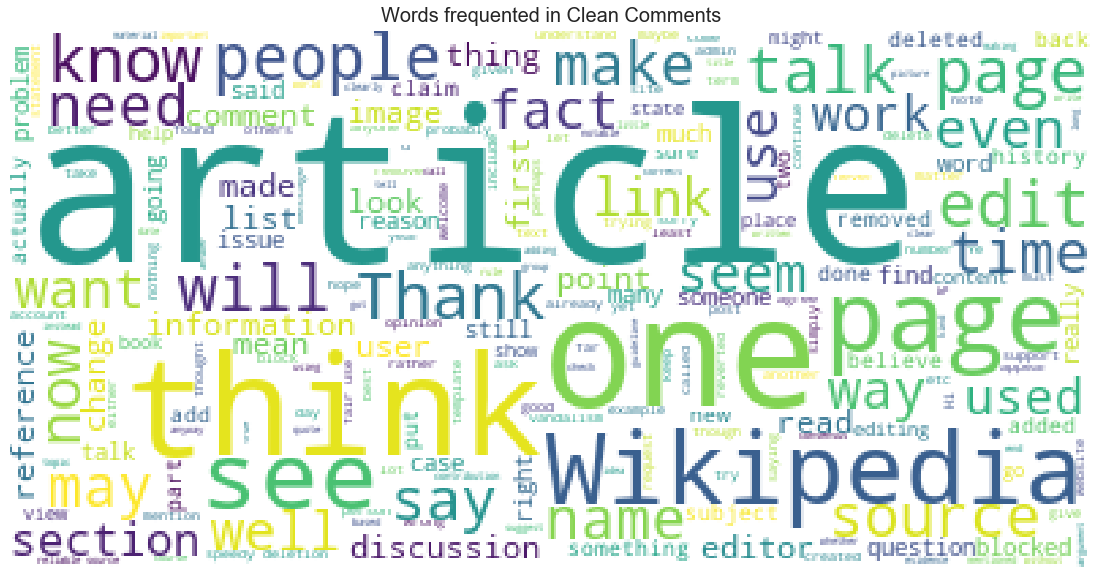

In [91]:
#wordcloud for clean comments
subset=toxic_train[toxic_train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

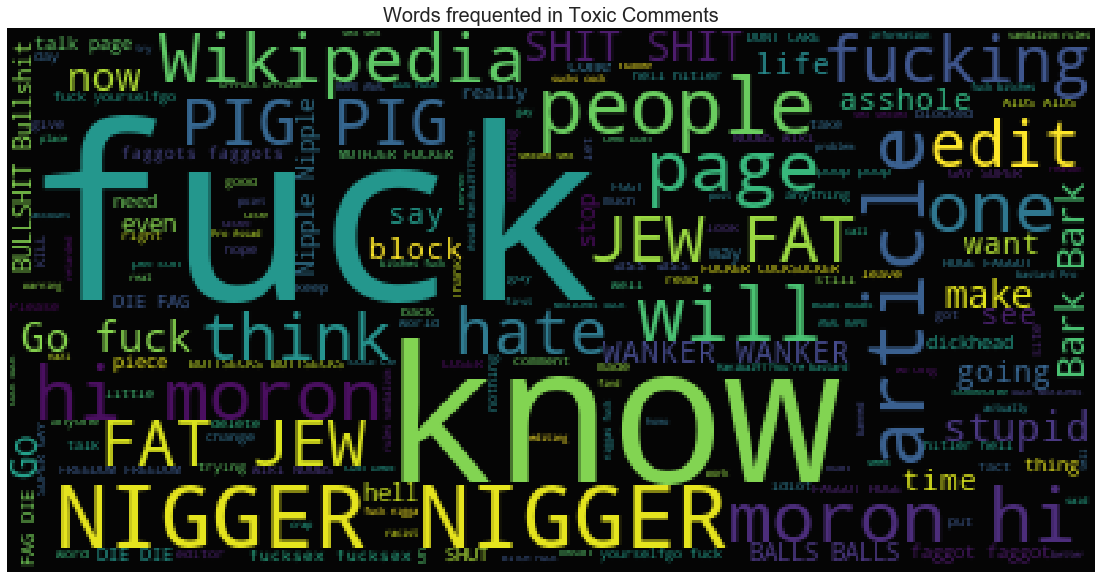

In [92]:
#wordcloud for toxic comments
subset=toxic_train[toxic_train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

There is still few stopwords in this context like 'know', 'Wikipedia', 'will' that doesn't add much value. What we can do is search for common word in every comment and add them to the list of stopwords

## Begin cleaning the data by removing punctuation and stopwords

In [41]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Creating pipeline 